This notebook contains code to infer the distribution of selection coefficients for different functional categories

In [2]:
%pylab inline
import glob
import numpy as np
import sys
import os
import seaborn as sns
sys.path.append("/storage/BonnieH/selection_project/helper_functions")
from Joint_method_functions import *
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

PLOTDIR = 'pdfs-round1'
PREFIX = 'Figure3-'
RESFOLDER = '/gymreklab-tscc/bonnieh/joint_method/results_top_x'

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
# PLot cdf of gamma distribution posterior estimates for real data

def main():
    print('Running main')
    
    folder = 'motif_analysis_diff_mu_071921' #'motif_analysis_diff_mu_071921' #'motif_analysis_diff_beta_071921' #'motif_analysis_diff_rho_071921' #'motif_analysis_same_mu'
    fig_num = 0
    pers = [2,3,4]
    #color_list = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','b','k']
    color_list = ['red','orange','lawngreen','forestgreen','turquoise','blue','purple','brown','slategray','yellow','gold']
    
    motif_dic = {}
    motif_dic[2] = ['AC','AG','AT']
    motif_dic[3] = ['ACC','AGG','AGC','CCG','AAG','AAC','ATC','AAT']
    motif_dic[4] = ['AAGG','AAAT','ATCC','AATC','AAAC','AATG','ACAT','AGAT','AAAG']
    
    subplots_dic = {}
    subplots_dic[2] = [(3,4,1),(3,4,2),(3,4,3),(3,4,4),(3,4,5),(3,4,6),(3,4,7),(3,4,8),(3,4,10),(3,4,11)]
    subplots_dic[3] = [(3,3,1),(3,3,2),(3,3,3),(3,3,4),(3,3,5),(3,3,6),(3,3,7),(3,3,8),(3,3,9)]
    subplots_dic[4] = [(2,2,1),(2,2,2),(2,2,3),(2,2,4)]
    
    for per in pers:
    
        opt_dic = {}
        opt_dic[2] = range(11,21,1) 
        opt_dic[3] = range(5,14,1)
        opt_dic[4] = range(7,11,1)

        gamma_dic = {}
        color_dic_motif={}
        color_dic_opt={}
        i = -1
        for motif in motif_dic[per]:
            gamma_dic[motif] = []
            i = i + 1
            color_dic_motif[motif] = color_list[i]

        '''
        i = -1
        for opt in opt_dic[per]:
            i = i + 1
            color_dic_opt[(per, opt)] = color_list[i]
        '''   

        # Plot motifs (sep graph for each opt allele)
        for motif in motif_dic[per]:
            opt_alleles = opt_dic[per]

            index = -1
            for opt in opt_alleles:
                opt_string = str(opt)
                if opt < 10:
                    opt_string = '0' + opt_string

                file_list = glob.glob('%s/%s/per_%d_%s*_opt_%s.txt'%(RESFOLDER, folder, per, motif, opt_string))
                file_list.sort() 

                base_plot = ''

                for filename in file_list:
                    #print(filename)
                    results_file = open(filename, 'r')
                    lines = results_file.readlines()
                    line = lines[4]
                    info = line.strip().split(': ')
                    num_acc = int(info[1])
                    line = lines[1]
                    info = line.strip().split(': ')
                    #num_loci = info[1]
                    #num_loci = num_loci.strip().split(' ')
                    #num_loci = int(num_loci[0])
                    # Use actual num loci
                    num_loci = int(info[2])

                    if num_acc > 0: # and num_loci >= 10:

                        line = lines[2]
                        info = line.strip().split(': ')
                        column = info[1]
                        column = column.strip().split(' ')
                        column = int(column[0])
                        opt_allele = int(info[3])

                        if column != 'H':
                            line = lines[6]
                            info = line.strip().split(',')
                            k = float(info[0])
                            theta = float(info[1])

                            gamma_dic[motif].append((k, theta, num_loci, opt))

        cum_dic = {}
        num_loci_dic = {}
        for motif in motif_dic[per]:
            num_loci_dic[motif] = [0] * len(opt_dic[per])
        for motif in motif_dic[per]:
            weighted_list = gamma_dic[motif]

            s = [] # List of s values drawn from gamma distribution

            for opt in weighted_list:
                num_sims = opt[2]
                k = opt[0]
                theta = opt[1]
                opt_allele = opt[3]

                num_loci_dic[motif][opt_allele-opt_dic[per][0]] = num_sims

                for i in range (0, num_sims):
                    s_val = np.random.gamma(k, theta)
                    if s_val > 0.1:
                        s_val = 0.1

                    s.append(s_val)

            bins_list = [0]
            exponents = [10**-5, 10**-4, 10**-3, 10**-2]
            for j in exponents:
                for i in np.arange(1,10,0.01):
                    bins_list.append(i*j)

            bins_list.append(0.1)
            bins_list.append(1)

            values, base = np.histogram(s, bins=bins_list)# [0,10**-5,10**-4,10**-3,10**-2,10**-1,1]#[0,10**-5,10**-4,10**-3,10**-2,10**-1,1]

            cumulative = list(np.cumsum(values))
            maximum = max(cumulative)
            cumulative_scaled = []
            for elem in cumulative:
                elem = elem/maximum
                cumulative_scaled.append(elem)

            cum_dic[motif] = cumulative_scaled
            base_plot = base

        # Plot CDF

        index = index + 1
        
        fig_num = fig_num + 1
        fig = plt.figure(fig_num)
        for elem in cum_dic:

            plt.plot(base_plot[:-1], cum_dic[elem], label = elem + ' Joint', color=color_dic_motif[elem], linewidth = 1, ls='solid') # (' + str(elem[2]) + ' loci)

        plt.xlim(10**-5, 0.1)
        plt.xscale('log')
        plt.title('Motif analysis')
        plt.xlabel('s', fontsize=15)
        plt.legend(bbox_to_anchor=(1, 1)) 
        plt.ylabel('Cumulative Frequency')

        #handles, labels = ax.get_legend_handles_labels()
        #fig.legend(handles, labels) #, 
        fig.tight_layout()
        plt.savefig(os.path.join(PLOTDIR, PREFIX + 'motif_analysis_per_%d.pdf'%(per)),bbox_inches='tight')
        #plt.savefig(PLOTDIR + 'diff_beta_motif_analysis_per_%d.pdf'%(per),bbox_inches='tight')
        #plt.savefig(PLOTDIR + 'diff_rho_motif_analysis_per_%d.pdf'%(per),bbox_inches='tight')
        #plt.savefig(PLOTDIR + 'same_mu_motif_analysis_per_%d.pdf'%(per),bbox_inches='tight')
        plt.show()
        print('Done')

        for motif in num_loci_dic:
            fig_num = fig_num + 1
            fig = plt.figure(fig_num)
            x = []
            for elem in opt_dic[per]:
                x.append(str(elem))
            plt.bar(x, num_loci_dic[motif],color=color_dic_motif[motif])
            plt.xlabel('Optimal allele',size=15)
            plt.ylabel('Number of loci',size=15)
            plt.title(motif,size=15)
            plt.xticks(fontsize=15) 
            plt.yticks(fontsize=15)

Running main


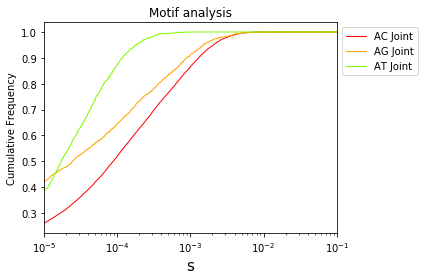

Done


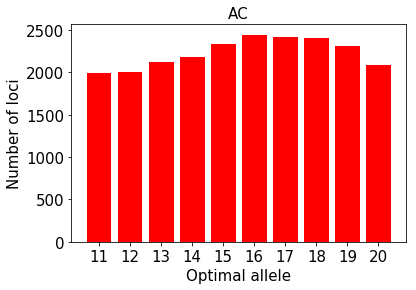

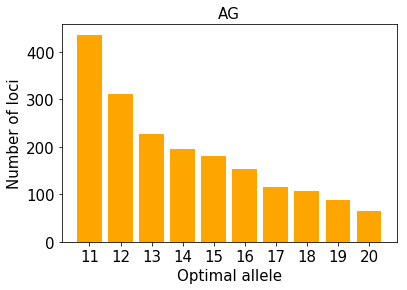

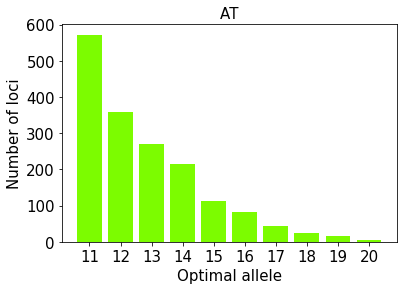

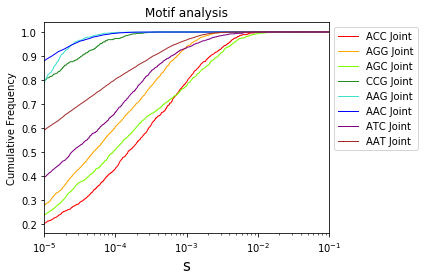

Done


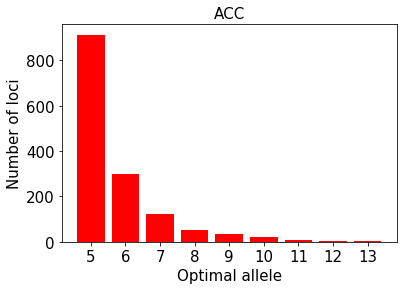

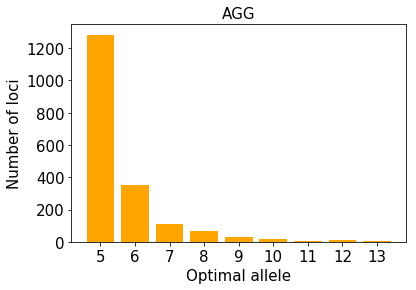

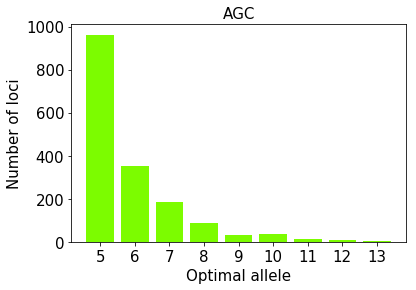

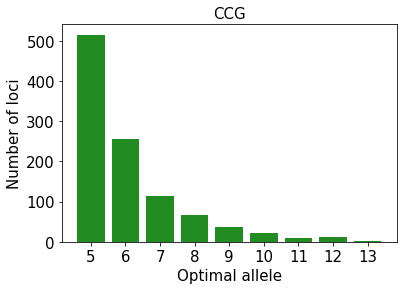

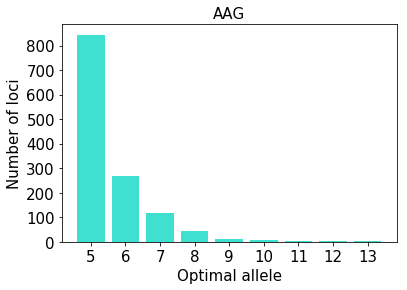

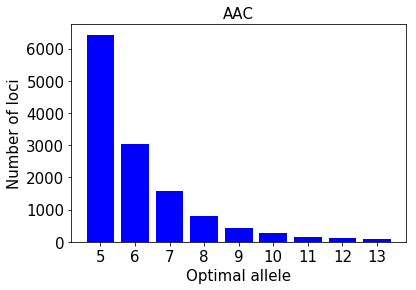

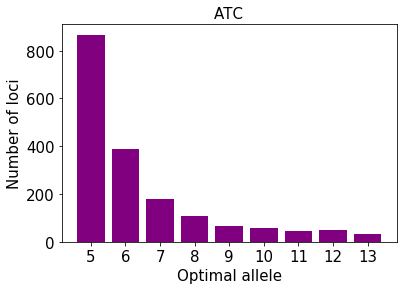

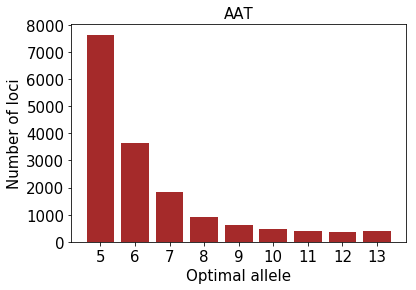

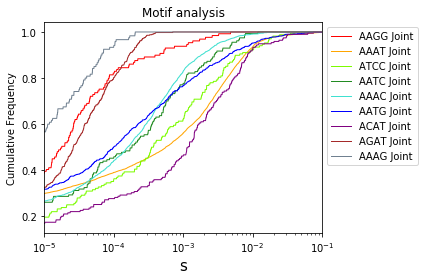

Done
CPU times: user 8.26 s, sys: 140 ms, total: 8.4 s
Wall time: 9.42 s


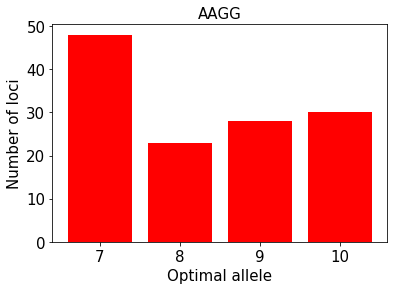

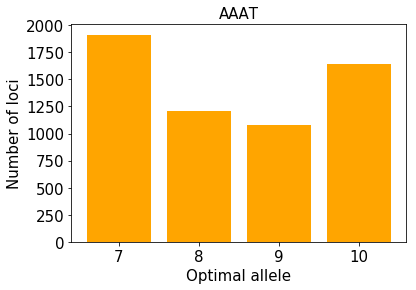

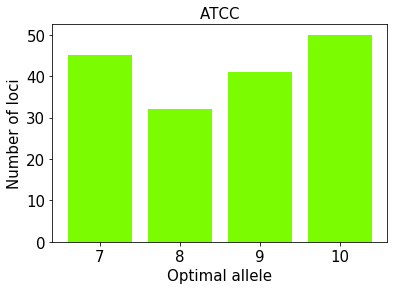

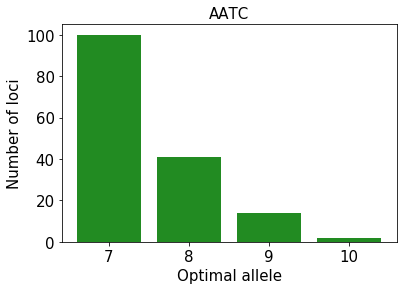

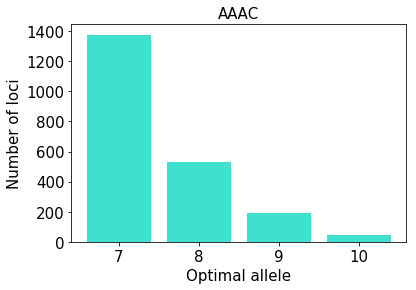

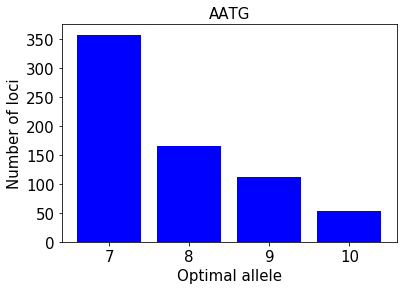

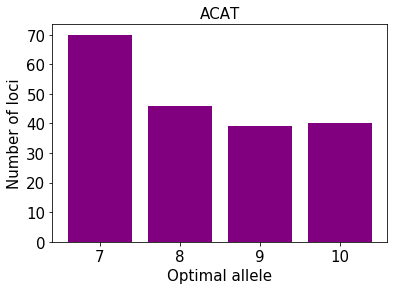

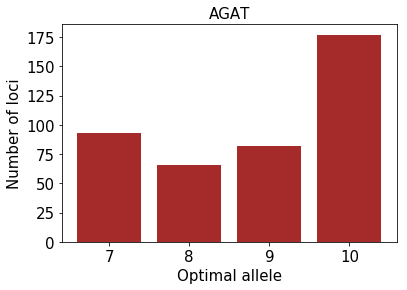

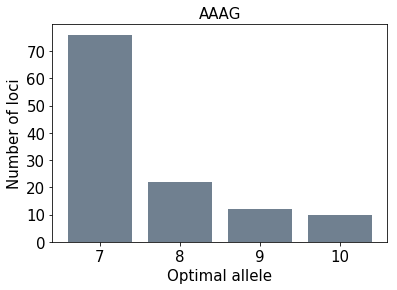

In [4]:
%%time
if __name__ == '__main__':
    main()